In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'ADA'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.025160,0.035060,0.025006,0.032053,0.032053,18716200
2017-11-10,0.032219,0.033348,0.026451,0.027119,0.027119,6766780
2017-11-11,0.026891,0.029659,0.025684,0.027437,0.027437,5532220
2017-11-12,0.027480,0.027952,0.022591,0.023977,0.023977,7280250
2017-11-13,0.024364,0.026300,0.023495,0.025808,0.025808,4419440


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-15,0.428069,0.454588,0.426750,0.452988,0.452988,357450532
2024-05-16,0.452996,0.461976,0.449552,0.459695,0.459695,367462393
2024-05-17,0.459696,0.489945,0.455974,0.482000,0.482000,447612110
2024-05-18,0.482000,0.485514,0.476550,0.482408,0.482408,240076401
2024-05-19,0.482408,0.483018,0.465600,0.467602,0.467602,250323995


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.467602

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998242,0.997277,0.996891,0.996891,0.675704
High,0.998242,1.000000,0.996516,0.998810,0.998810,0.694674
Low,0.997277,0.996516,1.000000,0.997901,0.997901,0.656704
Close,0.996891,0.998810,0.997901,1.000000,1.000000,0.682950
Adj Close,0.996891,0.998810,0.997901,1.000000,1.000000,0.682950
Volume,0.675704,0.694674,0.656704,0.682950,0.682950,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,0.032053,18716200
2017-11-10,0.027119,6766780
2017-11-11,0.027437,5532220
2017-11-12,0.023977,7280250
2017-11-13,0.025808,4419440
...,...,...
2024-05-15,0.452988,357450532
2024-05-16,0.459695,367462393
2024-05-17,0.482000,447612110


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,0.407701,82263800,0.437319,0.269667,0.175326
2017-12-29,0.529299,266403008,0.437121,0.284319,0.185270
2017-12-30,0.639243,645155968,0.452430,0.301631,0.197513
2017-12-31,0.719695,305947008,0.476615,0.321243,0.211358
2018-01-01,0.728657,150186000,0.508765,0.341120,0.225452


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-15,0.452988,357450532,0.445459,0.461288,0.509247
2024-05-16,0.459695,367462393,0.446000,0.461325,0.505471
2024-05-17,0.482000,447612110,0.450012,0.462581,0.502095
2024-05-18,0.482408,240076401,0.452998,0.463390,0.498456
2024-05-19,0.467602,250323995,0.453408,0.463351,0.494920


<Axes: xlabel='Date'>

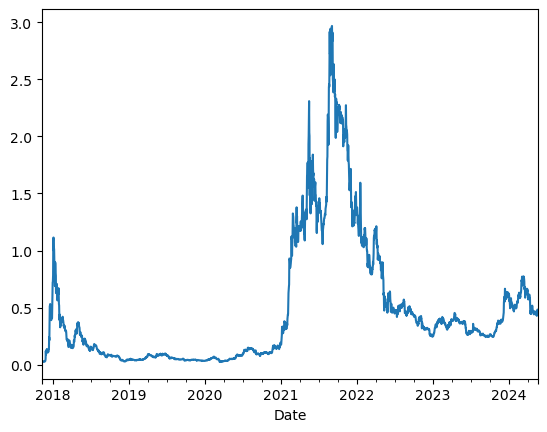

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,0.032053,18716200
1,2017-11-10,0.027119,6766780
2,2017-11-11,0.027437,5532220
3,2017-11-12,0.023977,7280250
4,2017-11-13,0.025808,4419440
...,...,...,...
2379,2024-05-15,0.452988,357450532
2380,2024-05-16,0.459695,367462393
2381,2024-05-17,0.482000,447612110
2382,2024-05-18,0.482408,240076401


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2469,2024-08-13
2470,2024-08-14
2471,2024-08-15
2472,2024-08-16
2473,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2444,2024-07-19,0.542625,0.238848,0.645477,0.509140,0.579813,-0.100704,-0.100704,-0.100704,-0.001230,-0.001230,-0.001230,-0.099474,-0.099474,-0.099474,0.0,0.0,0.0,0.441921
2445,2024-07-20,0.543095,0.254555,0.659574,0.508532,0.581857,-0.099242,-0.099242,-0.099242,0.002246,0.002246,0.002246,-0.101488,-0.101488,-0.101488,0.0,0.0,0.0,0.443853
2446,2024-07-21,0.543565,0.226475,0.664241,0.508057,0.583820,-0.101004,-0.101004,-0.101004,0.002610,0.002610,0.002610,-0.103614,-0.103614,-0.103614,0.0,0.0,0.0,0.442561
2447,2024-07-22,0.544035,0.240932,0.637193,0.507195,0.585849,-0.106271,-0.106271,-0.106271,-0.000489,-0.000489,-0.000489,-0.105782,-0.105782,-0.105782,0.0,0.0,0.0,0.437764
2448,2024-07-23,0.544505,0.235961,0.629506,0.507354,0.588337,-0.110648,-0.110648,-0.110648,-0.002736,-0.002736,-0.002736,-0.107912,-0.107912,-0.107912,0.0,0.0,0.0,0.433857
2449,2024-07-24,0.544975,0.229708,0.656279,0.506266,0.589999,-0.109876,-0.109876,-0.109876,0.000039,0.000039,0.000039,-0.109916,-0.109916,-0.109916,0.0,0.0,0.0,0.435099
2450,2024-07-25,0.545445,0.226409,0.645870,0.506458,0.590713,-0.112141,-0.112141,-0.112141,-0.000441,-0.000441,-0.000441,-0.111701,-0.111701,-0.111701,0.0,0.0,0.0,0.433303
2451,2024-07-26,0.545915,0.219428,0.643893,0.506839,0.592678,-0.114399,-0.114399,-0.114399,-0.001230,-0.001230,-0.001230,-0.113169,-0.113169,-0.113169,0.0,0.0,0.0,0.431515
2452,2024-07-27,0.546384,0.229938,0.658588,0.506725,0.594010,-0.111978,-0.111978,-0.111978,0.002246,0.002246,0.002246,-0.114224,-0.114224,-0.114224,0.0,0.0,0.0,0.434406
2453,2024-07-28,0.546854,0.242058,0.637620,0.505918,0.595484,-0.112157,-0.112157,-0.112157,0.002610,0.002610,0.002610,-0.114767,-0.114767,-0.114767,0.0,0.0,0.0,0.434698


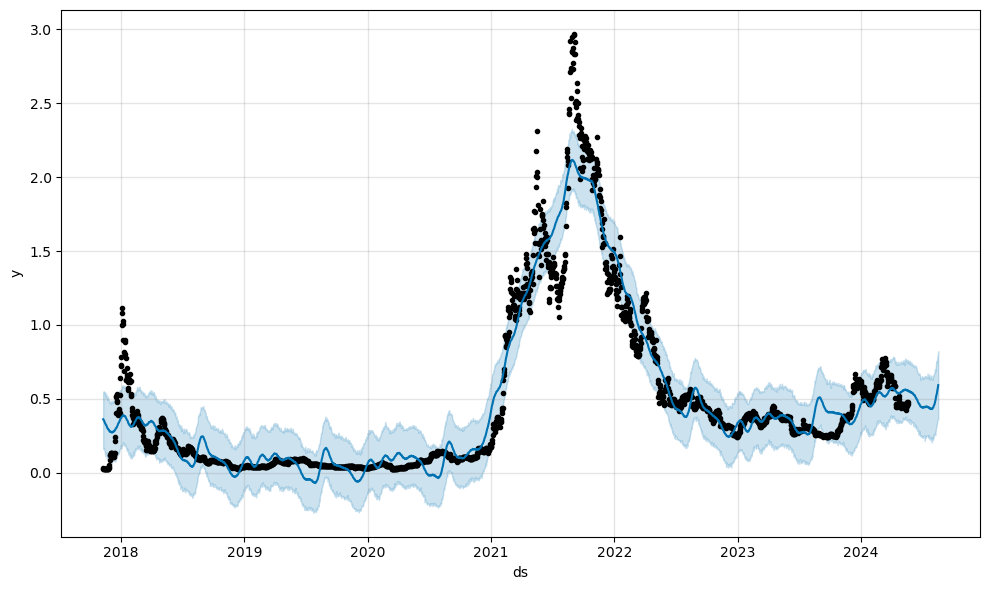

In [20]:
# Plot the Prophet predictions for the data
fig1 = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,0.554691,0.357588,0.757005
2024-05-21,0.551233,0.342963,0.749993
2024-05-22,0.552784,0.360825,0.736559
2024-05-23,0.551079,0.335827,0.750530
2024-05-24,0.549070,0.362125,0.759453
...,...,...,...
2024-08-13,0.538148,0.330932,0.755399
2024-08-14,0.553444,0.342275,0.770190
2024-08-15,0.565582,0.356858,0.793223


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

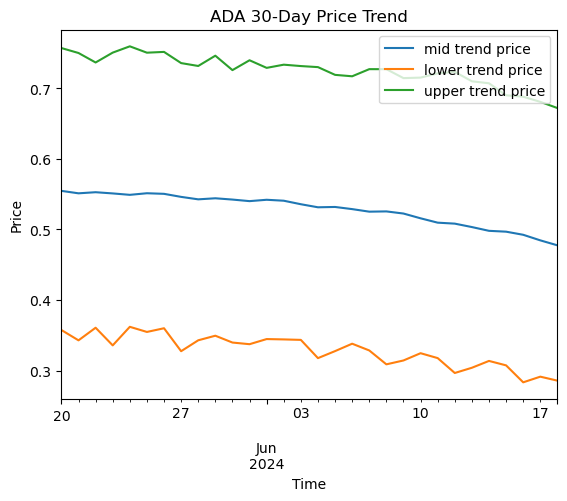

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

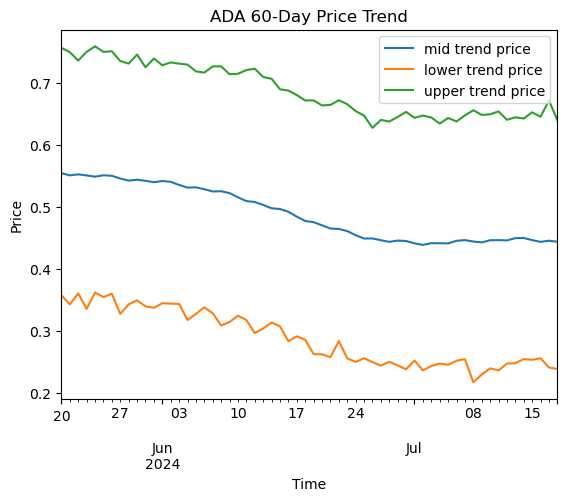

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

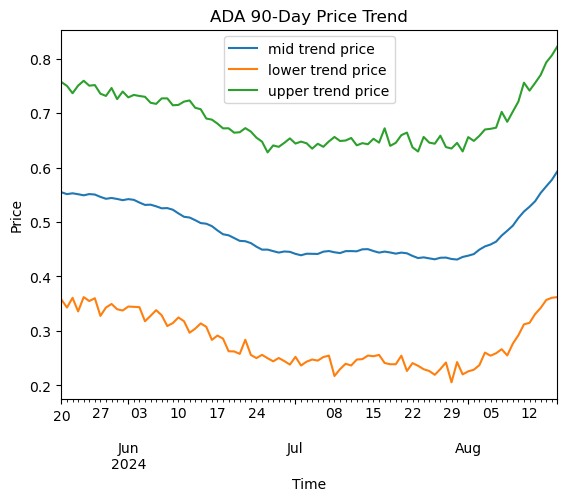

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

0.467602

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.5546910042042172

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

0.5111465021021087

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

0.5557332555010656

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

0.4723524902001091

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

0.44201761500182263

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

0.5928954350794914

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.076

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.135

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.16

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

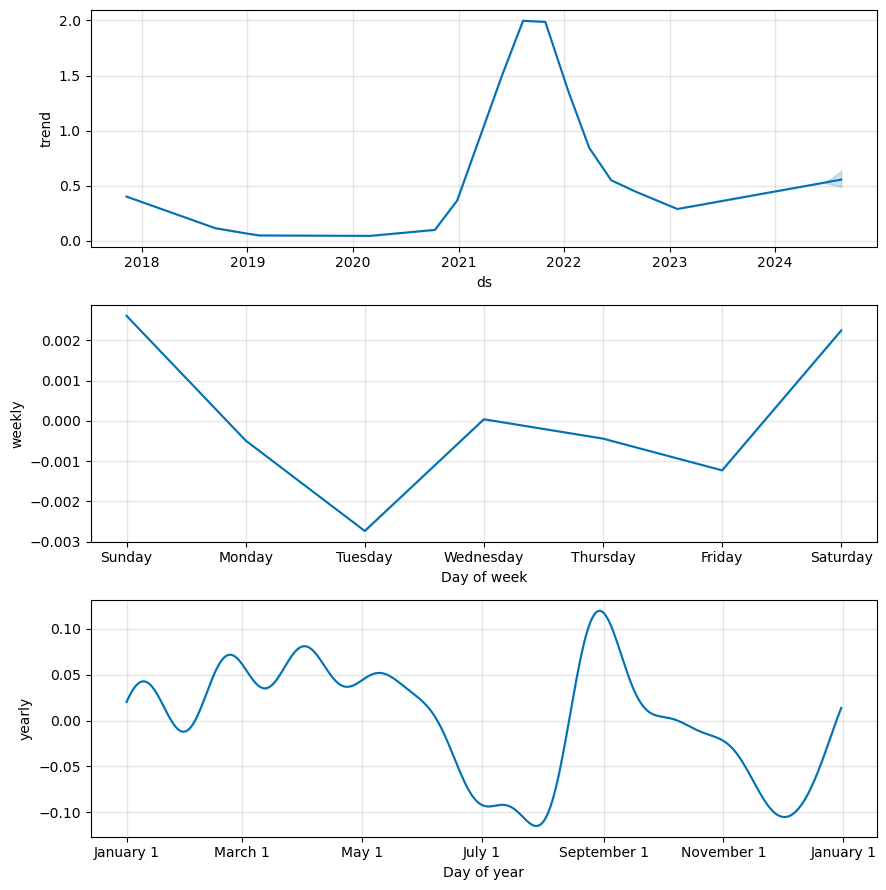

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig2 = crypto_model.plot_components(crypto_forecast)

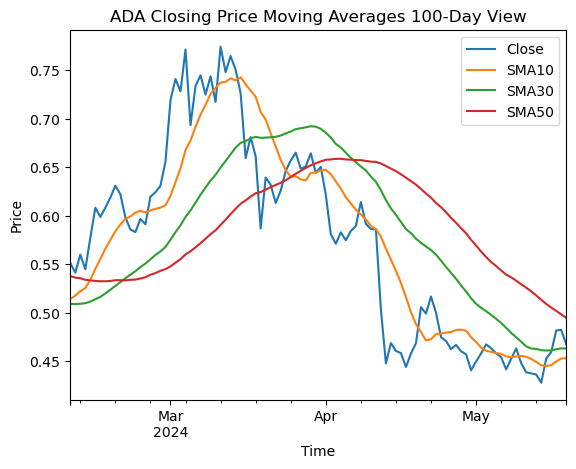

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

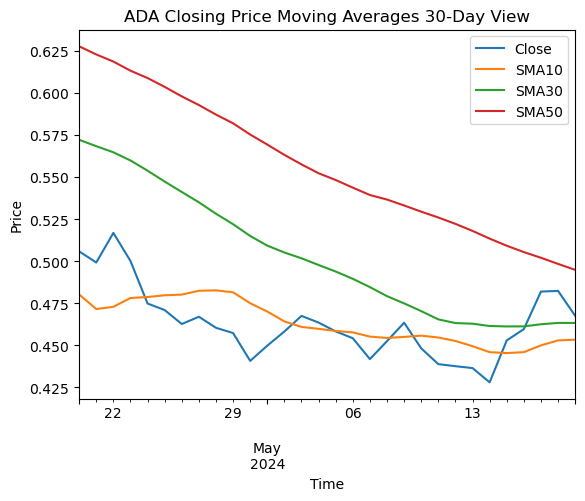

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-20
File created :  2024-05-20.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.467602,0.016141654551261597,-0.048511607018260405,0.26698037580557354
BNB,574.63,-0.3370363083405419,-0.3290568236386213,-0.2790790471601129
BONK,2.5e-05,0.25779530706847753,0.4080859075709553,0.5429258111537147
BTC,66278.37,-0.2191180233361938,-0.1951255528263407,-0.16020045358030566
DOGE,0.149107,-0.22857973922643027,-0.28954294972299366,-0.13383869168157447
ETH,3094.12,-0.05566025624110993,-0.04356552970504457,0.046438254274701274
PEPE,9e-06,0.3163098292378519,0.5695209080409678,0.79019064181281
SHIB,2.4e-05,-0.13447450951251372,-0.07783705937680974,-0.018044767636294923
SOL,170.09,0.02993653747852032,0.09897686371903935,0.15883864333841902
XRP,0.509661,0.08170842018061886,0.1175389631277377,0.251808862234169
ADA,0.467602,-0.05356931769426376,-0.12050457682285454,0.1829944797779357
ADA,0.467602,-0.07589607234414741,-0.135242805763105,0.15993249027663747

